# Introduction to Multi-Armed Bandits——04 Thompson Sampling[2]

## 参考资料

1. Russo D J, Van Roy B, Kazerouni A, et al. A tutorial on thompson sampling[J]. Foundations and Trends® in Machine Learning, 2018, 11(1): 1-96.

2. [ts_tutorial](https://github.com/iosband/ts_tutorial)

项目代码地址: [https://github.com/yijunquan-afk/bandit-learning.git](https://github.com/yijunquan-afk/bandit-learning.git)

# 一、General Thompson Sampling

`Thompson Sampling` 可以有效应用于 `Bernoulli bandit` 以外的一系列在线决策问题，我们现在考虑一个更普适的设置。

+ 假设智能体(`agent`) 从集合 $\mathcal{X}$ 选取一连串的动作(`action`) $x_1, x_2, x_3,\cdots,$ 并应用于一个系统。

+ 行动集可以是有限的，如`Bernoulli bandit`，也可以是无限的。

+ 在应用动作 $x_t$ 之后，智能体观察到一个结果 $y_t$，这是由系统根据条件概率 $q_\theta(\cdot | x_t)$ 随机生成的。

+ 智能体获得奖励 $r_t=r(y_t)$，其中 $r$ 是一个已知的函数。 智能体最初不知道 $\theta$ 的值，并使用先验分布 $p$ 表示他的不确定性。

算法 4.1 和 4.2 以一种抽象的形式提出了贪心和TS方法，以适应这个更普适的设置。两者的区别在于它们生成模型参数 $\hat{\theta}$ 的方式。贪婪算法将 $\hat{\theta}$ 作为 $\theta$ 相对于分布 $p$ 的期望值，而TS从 $p$ 中抽取一个随机样本。 然后，这两种算法都采取了使各自模型的预期奖励最大化的动作。

![image-20230121094845060](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230121094845060.png)

![image-20230121094912939](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230121094912939.png)


如果有一组有限的可能观测值$y_t$，这个期望值由以下公式给出
$$
\mathbb{E}_{q_{\hat{\theta}}}[r(y_t) | x_t = x] = \sum_o q_{\hat{\theta}}(o|x) r(o) \tag{4.1}
$$

分布 $p$ 根据已实现的观测值 $\hat{y}_t$ 的条件进行更新。 如果 $\theta$ 被限制在一个有限的集合中，这个条件分布可以被贝叶斯规则写成
$$
\mathbb{P}_{p, q}(\theta = u | x_t, y_t) = \frac{p(u) q_u(y_t | x_t)}{\sum_v p(v) q_v(y_t | x_t)}\tag{4.2}
$$

带有β先验的`Bernoulli bandit`是上述表述的一个特例。 在这种特殊情况下，动作的集合是 $\mathcal{X} = \{1,\ldots,K\}$，只有奖励被观察到，所以 $y_t = r_t$ 。 观察和奖励是由条件概率 $q_\theta(1|k) = \theta_k$ and $q_\theta(0|k) = 1-\theta_k$ 来模拟的。先验分布由向量 $\alpha$ 和 $\beta$ 决定。其概率密度函数为：
$$
p(\theta) = \prod_{k=1}^K \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha_k)\Gamma(\beta_k)} \theta_k^{\alpha_k-1} (1-\theta_k)^{\beta_k-1}
$$

换句话说，在先验分布下，$\theta$ 的组成部分是独立的，并且是β分布的，参数为$\alpha$ 和 $\beta$。

对于这个问题，贪心算法（算法4.1）和TS算法（算法4.2}）在每个 $t$ 的迭代中，对于 $k \in \{1,\cdots,K\}$ 的后验参数以$(\alpha_k,\beta_k)$ 开始。 贪心算法将 $\hat{\theta}_k$ 设定为期望，$\mathbb{E}_p[\theta_k] = \alpha_k/(\alpha_k+\beta_k)$，而TS从参数为 $(\alpha_k,\beta_k)$ 的beta分布中随机抽取 $\hat{\theta}_k$ 。然后，每个算法都会选择使 $\mathbb{E}_{q_{\hat{\theta}}}[r(y_t) | x_t = x] = \hat{\theta}_x$ 达到最大的动作 $x$。在应用选定的动作后，观察到奖励 $r_t = y_t$ ，并根据以下原则更新分布参数

$$
(\alpha, \beta) \leftarrow (\alpha + r_t {\bf 1}_{x_t}, \beta + (1-r_t) {\bf 1}_{x_t})
$$

其中 ${\bf 1}_{x_t}$是一个分量 $x_t$ 等于 $1$，所有其他分量等于 $0$ 的向量。

算法4.1和算法4.2还可以应用在更复杂的场景，让我们来看看最短路问题。

# 二、在线最短路问题

## 2.1 问题描述

一个人每天早上往返于家与单位之间。她想沿着平均遍历时间最少的路通勤，但她不确定不同路线的遍历时间。她该如何有效地学习，并在大量的遍历中尽量减少总遍历时间?

对于最短路问题，模型构建如下：

+ 一个图 $G = (V, E)$ , $N$ 个点 $V = \{1,\ldots, N\}$，边 $E$ 以及平均遍历时间(`mean travel times`) $\theta \in \mathbb{R}^{N}$。

+ 点 $1$ 是起点，点 $N$ 是终点。

+ 一个动作是一连串从起点到终点的不同边。

+ 采取一个动作 $x_t$ 以后，对于每一个经过的边 $e \in x_t$，智能体观察到一个遍历时间 $y_{t,e}$，该遍历时间是从具有平均值 $\theta_e$ 的分布中独立抽样得到的。

+ 遍历过程中，智能体产生消耗 $\sum_{e \in x_t} y_{t,e}$，于是奖励可以量化为 $r_t = -\sum_{e \in x_t} y_{t,e}$。

![image-20230125161441139](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230125161441139.png)




## 2.2 Independent Travel Times


考虑先验分布：$\theta_e$ 是独立的与`log-Gaussian-distributed`（参数为 $\mu_e$ 和 $\sigma_e^2$）。也就是说，$\ln(\theta_e) \sim N(\mu_e, \sigma_e^2)$ 是高斯分布。因此，$\mathbb{E}[\theta_e] = e^{\mu_e + \sigma_e^2/2}$。此外，我们认为 $y_{t,e}|\theta$ 在各个边$e \in E$ 上是独立的，并且是对数高斯分布，参数为$\ln(\theta_e) - \tilde{\sigma}^2/2$ 和 $\tilde{\sigma}^2$，因此 $\mathbb{E}[y_{t,e}|\theta_e] = \theta_e$。 共轭特性适应于在观察 $y_{t,e}$ 时更新$\theta_e$ 分布:

$$
(\mu_e, \sigma_e^2) \leftarrow \left(\frac{\frac{1}{\sigma_e^2} \mu_e + \frac{1}{\tilde{\sigma}^2} \left(\ln(y_{t,e}) +\frac{\tilde{\sigma}^2}{2}\right)}{\frac{1}{\sigma_e^2} + \frac{1}{\tilde{\sigma}^2}},  \frac{1}{\frac{1}{\sigma_e^2} + \frac{1}{\tilde{\sigma}^2}}\right) \tag{4.3}

$$

> 对于先验分布和后验分布属于同类别的分布，则先验与后验称为共轭分布，而先验分布被称为似然函数的共轭先验。

让我们用一个例子进行具体的说明：考虑到一个人每天从家到公司。假设可能的路径用图 $G = (V, E)$ 表示，同时假设这个人知道每个边 $e \in E$ 边的遍历距离 $d_e$，但是对平均遍历时间不确定。对他来说，构建一个期望等于遍历距离的先验是很自然的。对于对数高斯先验，可以通过设置 $\mu_e = \ln(d_e) -\sigma_e^2/2$来实现。此时，$\mathbb{E}[\theta_e] = d_e$。参数 $\mu_e$ 和 $\sigma_e^2$ 也表达了不确定性的程度；一条边的平均遍历时间的先验方差是$(e^{\sigma_e^2}-1) d_e^2$。[对数正态分布](https://baike.baidu.com/item/%E5%AF%B9%E6%95%B0%E6%AD%A3%E6%80%81%E5%88%86%E5%B8%83/8976782?fr=aladdin)。

算法4.1和4.2可以应用在最短路问题上。在每个 $t$ 的迭代中，对于 $e \in E$ 的后验参数以$(\mu_e,\sigma_e)$ 开始。 贪心算法将 $\hat{\theta}_e$ 设定为期望，$\mathbb{E}_p[\theta_e] = e^{\mu_e + \sigma_e^2/2}$，而TS从参数为 $\mu_e$ 和 $\sigma_e^2$ 的对数高斯分布中随机抽取 $\hat{\theta}_e$ 。然后，每个算法都会选择使 $\mathbb{E}_{q_{\hat{\theta}}}[r(y_t) | x_t = x] = -\sum_{e \in x_t} \hat{\theta}_e$ 达到最大的动作 $x$。在应用选定的动作后，观察到输出 $y_t$ ，并根据公式4.3更新分布参数 $(\mu_e, \sigma_e^2)$ 。

### 代码实现与分析

图使用`binomial bridge`的形式。有20层，所以从源头到目的地有184,756条路径。先验参数设置为 $\mu_e = -\frac{1}{2}$ 和 $\sigma_e^2 = 1$ ，于是 $\mathbb{E}[\theta_e] = 1$ ，$e \in E$，以及条件分布参数为 $\tilde{\sigma}^2 = 1$。每个数据点代表了一万次独立模拟的平均值。

实现Dijkstra单源最短路算法：

In [1]:
from __future__ import generators


class priorityDictionary(dict):
    def __init__(self):
        '''Initialize priorityDictionary by creating binary heap of
        pairs (value,key). Note that changing or removing a dict entry
        will not remove the old pair from the heap until it is found by
        smallest() or until the heap is rebuilt.'''
        self.__heap = []
        dict.__init__(self)

    def smallest(self):
        '''Find smallest item after removing deleted items from front of
        heap.'''
        if len(self) == 0:
            raise IndexError("smallest of empty priorityDictionary")
        heap = self.__heap
        while heap[0][1] not in self or self[heap[0][1]] != heap[0][0]:
            lastItem = heap.pop()
            insertionPoint = 0
            while 1:
                smallChild = 2 * insertionPoint + 1
                if smallChild + 1 < len(heap) and \
                        heap[smallChild] > heap[smallChild + 1]:
                    smallChild += 1
                if smallChild >= len(heap) or lastItem <= heap[smallChild]:
                    heap[insertionPoint] = lastItem
                    break
                heap[insertionPoint] = heap[smallChild]
                insertionPoint = smallChild
        return heap[0][1]

    def __iter__(self):
        '''Create destructive sorted iterator of priorityDictionary.'''
        def iterfn():
            while len(self) > 0:
                x = self.smallest()
                yield x
                del self[x]
        return iterfn()

    def __setitem__(self, key, val):
        '''Change value stored in dictionary and add corresponding pair
        to heap. Rebuilds the heap if the number of deleted items gets
        large, to avoid memory leakage.'''
        dict.__setitem__(self, key, val)
        heap = self.__heap
        if len(heap) > 2 * len(self):
            self.__heap = [(v, k) for k, v in self.items()]
            self.__heap.sort()
            # builtin sort probably faster than O(n)-time heapify
        else:
            newPair = (val, key)
            insertionPoint = len(heap)
            heap.append(None)
            while insertionPoint > 0 and \
                    newPair < heap[(insertionPoint - 1) // 2]:
                heap[insertionPoint] = heap[(insertionPoint - 1) // 2]
                insertionPoint = (insertionPoint - 1) // 2
            heap[insertionPoint] = newPair

    def setdefault(self, key, val):
        '''Reimplement setdefault to pass through our customized __setitem__.'''
        if key not in self:
            self[key] = val
        return self[key]

def Dijkstra(G,start,end=None):

  D = {}  # dictionary of final distances
  P = {}  # dictionary of predecessors
  Q = priorityDictionary()   # est.dist. of non-final vert.
  Q[start] = 0

  for v in Q:
    D[v] = Q[v]
    if v == end: break

    for w in G[v]:
      vwLength = D[v] + G[v][w]
      if w in D:
        if vwLength < D[w]:
          raise ValueError("Dijkstra: found better path to already-final vertex")
      elif w not in Q or vwLength < Q[w]:
        Q[w] = vwLength
        P[w] = v

  return (D,P)

def shortestPath(G,start,end):
  D,P = Dijkstra(G,start,end)
  Path = []
  while 1:
    Path.append(end)
    if end == start: break
    end = P[end]
  Path.reverse()
  return Path


再来看环境(environment)：

In [2]:

import numpy as np
from base.environment import Environment
from collections import defaultdict
from graph.dijkstra import Dijkstra


class IndependentBinomialBridge(Environment):
    """Graph shortest path on a binomial bridge.

    The agent proceeds up/down for n_stages, but must end with equal ups/downs.
      e.g. (0, 0) - (1, 0) - (2, 0) for n_stages = 2
                  \        /
                    (1, 1)
    We label nodes (x, y) for x=0, 1, .., n_stages and y=0, .., y_lim
    y_lim = x + 1 if x < n_stages / 2 and then decreases again appropriately.
    """

    def __init__(self, n_stages, mu0, sigma0, sigma_tilde=1.):
        """
           graph[node1][node2] 表示node1 和 node2之间的边距

        Args:
          n_stages: 阶段数必须为偶数
          mu0: 独立分布的边的先验均值
          sigma0: 独立分布的边的先验标准差
          sigma_tilde: 标准差的观察噪声
        """
        assert (n_stages % 2 == 0)
        self.n_stages = n_stages
        self.mu0 = mu0
        self.sigma0 = sigma0
        self.sigma_tilde = sigma_tilde

        self.nodes = set()
        self.graph = defaultdict(dict)

        self.optimal_reward = None  # 当我们计算最短路径时填充

        self._create_graph()
        _ = self.get_shortest_path()

    def get_observation(self):
        """这里的观察值是阶段数"""
        return self.n_stages

    def _get_width_bridge(self, x):
        """在阶段x时计算bridge的宽度
        Args:
          x: 阶段数
        """
        depth = x - 2 * np.maximum(x - self.n_stages / 2, 0) + 1
        return int(depth)

    def _create_graph(self):
        """随机初始化图"""

        # 初始化结点
        for x in range(self.n_stages + 1):
            for y in range(self._get_width_bridge(x)):
                node = (x, y)
                self.nodes.add(node)

        # 添加边
        for x in range(self.n_stages + 1):
            for y in range(self._get_width_bridge(x)):
                node = (x, y)
                # 右上的结点
                right_up = (x + 1, y - 1)
                # 正右的结点
                right_equal = (x + 1, y)
                # 右下的结点
                right_down = (x + 1, y + 1)

                if right_down in self.nodes:
                    distance = np.exp(
                      # np.random.randn: 返回一个或一组服从标准正态分布的随机样本值。
                        self.mu0 + self.sigma0 * np.random.randn())
                    self.graph[node][right_down] = distance

                if right_equal in self.nodes:
                    distance = np.exp(
                        self.mu0 + self.sigma0 * np.random.randn())
                    self.graph[node][right_equal] = distance

                if right_up in self.nodes and right_equal not in self.nodes:
                    # 向上走
                    distance = np.exp(
                        self.mu0 + self.sigma0 * np.random.randn())
                    self.graph[node][right_up] = distance

    def overwrite_edge_length(self, edge_length):
        """用确切的值覆盖原先的边长

        Args:
          edge_length: edge_length[start_node][end_node] = distance
        """
        for start_node in edge_length:
            for end_node in edge_length[start_node]:
                self.graph[start_node][end_node] = edge_length[start_node][end_node]

    def get_shortest_path(self):
        """找到最短路

        Returns:
          path: 遍历的结点列表
        """
        start = (0, 0)
        end = (self.n_stages, 0)
        # 使用Dijkstra方法找到最短路
        final_distance, predecessor = Dijkstra(self.graph, start, end)

        path = []
        iter_node = end
        while True:
            path.append(iter_node)
            if iter_node == start:
                break
            iter_node = predecessor[iter_node]

        path.reverse()

        # 更新最优奖励
        self.optimal_reward = -final_distance[end]

        return path

    def get_optimal_reward(self):
        return self.optimal_reward

    def get_expected_reward(self, path):
        """给定一个路径，获取奖励

        Args:
          path: 结点列表

        Returns:
          expected_reward: -路长
        """
        expected_distance = 0
        # zip()是Python的一个内建函数，它接受一系列可迭代的对象作为参数，
        # 将对象中对应的元素打包成一个个tuple（元组），
        # 然后返回由这些tuples组成的list（列表）。
        for start_node, end_node in zip(path, path[1:]):
            expected_distance += self.graph[start_node][end_node]

        return -expected_distance

    def get_stochastic_reward(self, path):
        time_elapsed = defaultdict(dict)
        for start_node, end_node in zip(path, path[1:]):
            mean_time = self.graph[start_node][end_node]
            lognormal_mean = np.log(mean_time) - 0.5 * self.sigma_tilde**2
            stoch_time = np.exp(
                lognormal_mean + self.sigma_tilde * np.random.randn())
            time_elapsed[start_node][end_node] = stoch_time

        return time_elapsed

接下来设计智能体。

In [3]:
import copy
import random

class IndependentBBEpsilonGreedy():
    """Independent Binomial Bridge Epsilon Greedy"""

    def __init__(self, n_stages, mu0, sigma0, sigma_tilde, epsilon=0.0):
        """An agent for graph bandits.

        Args:
          n_stages: binomial bridge的阶段数 (必须是偶数)
          mu0: 先验的平均值
          sigma0: 先验的标准差
          sigma_tilde: 观察值的噪声
          epsilon: 用于选择的参数
        """
        assert (n_stages % 2 == 0)
        self.n_stages = n_stages
        self.mu0 = mu0
        self.sigma0 = sigma0
        self.sigma_tilde = sigma_tilde
        self.epsilon = epsilon

        # 使用任意初始值设置内部环境
        self.internal_env = IndependentBinomialBridge(n_stages, mu0, sigma0)

        # 将边的后验保存为后验belief的元组(mean, std)
        self.posterior = copy.deepcopy(self.internal_env.graph)
        for start_node in self.posterior:
            for end_node in self.posterior[start_node]:
                self.posterior[start_node][end_node] = (mu0, sigma0)

    def get_posterior_mean(self):
        """获得每条边的后验均值

        Returns:
          edge_length: edge_length[start_node][end_node] = distance
        """
        edge_length = copy.deepcopy(self.posterior)

        for start_node in self.posterior:
            for end_node in self.posterior[start_node]:
                mean, std = self.posterior[start_node][end_node]
                edge_length[start_node][end_node] = np.exp(mean + 0.5 * std**2)

        return edge_length

    def get_posterior_sample(self):
        """获得每条边的后验抽样

        Return:
          edge_length: edge_length[start_node][end_node] = distance
        """
        edge_length = copy.deepcopy(self.posterior)

        for start_node in self.posterior:
            for end_node in self.posterior[start_node]:
                mean, std = self.posterior[start_node][end_node]
                edge_length[start_node][end_node] = np.exp(mean + std * np.random.randn())

        return edge_length

    def update_observation(self, observation, action, reward):
        """为binomial bridge更新观察值.

        Args:
          observation: 阶段数
          action: 智能体选择的路(未使用)
          reward: reward[start_node][end_node] = stochastic_time
        """
        assert observation == self.n_stages

        for start_node in reward:
            for end_node in reward[start_node]:
                y = reward[start_node][end_node]
                old_mean, old_std = self.posterior[start_node][end_node]

                # 转换精度，便于计算
                old_precision = 1. / (old_std**2)
                noise_precision = 1. / (self.sigma_tilde**2)
                new_precision = old_precision + noise_precision

                new_mean = (noise_precision * (np.log(y) + 0.5 /
                            noise_precision) + old_precision * old_mean) / new_precision
                new_std = np.sqrt(1. / new_precision)

                # 更新后验值
                self.posterior[start_node][end_node] = (new_mean, new_std)

    def _pick_random_path(self):
        """在bridge中完全随机地选择一条路径"""
        path = []
        start_node = (0, 0)
        while True:
            path += [start_node]
            if start_node == (self.n_stages, 0):
                break
            start_node = random.choice(list(self.posterior[start_node].keys()))
        return path

    def pick_action(self, observation):
        """贪心地选择后验均值的最短路径"""
        if np.random.rand() < self.epsilon:
            path = self._pick_random_path()

        else:
            posterior_means = self.get_posterior_mean()
            self.internal_env.overwrite_edge_length(posterior_means)
            path = self.internal_env.get_shortest_path()

        return path


class IndependentBBTS(IndependentBBEpsilonGreedy):
    """Independent Binomial Bridge Thompson Sampling"""

    def pick_action(self, observation):
        """从后验中抽样"""
        posterior_sample = self.get_posterior_sample()
        self.internal_env.overwrite_edge_length(posterior_sample)
        path = self.internal_env.get_shortest_path()

        return path

设置实验，不需要管action。

In [4]:
from base.experiment import BaseExperiment

class ExperimentNoAction(BaseExperiment):

  def run_step_maybe_log(self, t):
    # 观察环境，选择臂
    observation = self.environment.get_observation()
    action = self.agent.pick_action(observation)

    # 计算有用的值
    optimal_reward = self.environment.get_optimal_reward()
    expected_reward = self.environment.get_expected_reward(action)
    reward = self.environment.get_stochastic_reward(action)

    # 使用获得的奖励和选择的臂更新智能体
    self.agent.update_observation(observation, action, reward)

    # 记录需要的值
    instant_regret = optimal_reward - expected_reward
    self.cum_optimal += optimal_reward
    self.cum_regret += instant_regret

    # 环境进化（非平稳实验中才会用到）
    self.environment.advance(action, reward)


    self.data_dict = {'t': (t + 1),
                      'instant_regret': instant_regret,
                      'cum_regret': self.cum_regret, 
                      'cum_optimal': self.cum_optimal,
                      'unique_id': self.unique_id}
    self.results.append(self.data_dict)

跑一下书上的例图。这里的试验次数设置为200次，书中的是跑了5000次的结果。

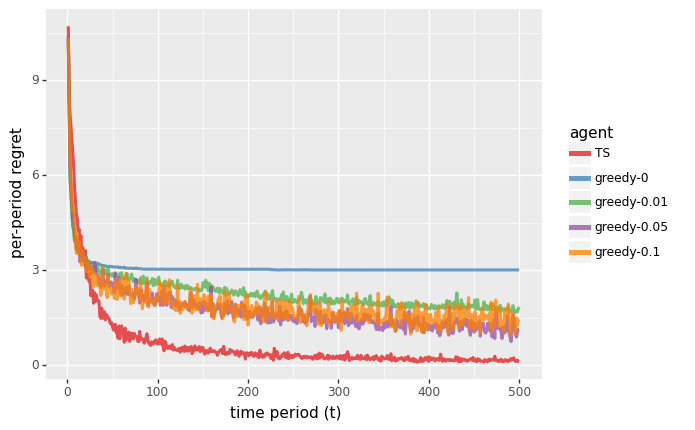

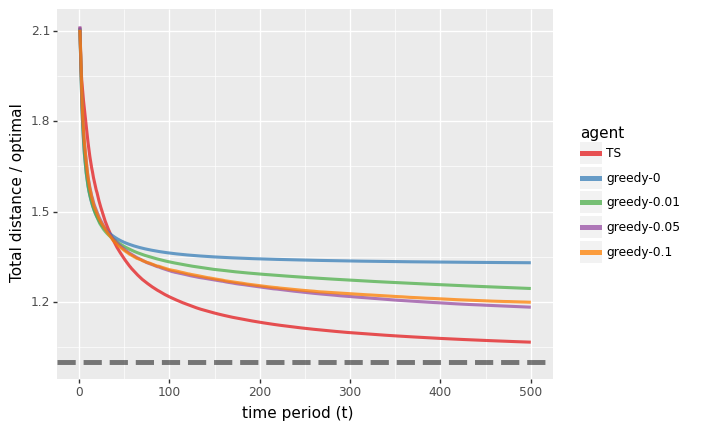

In [9]:
import pandas as pd
import plotnine as gg

def generateTSAgent(n_steps, n_stages, mu0, sigma0, sigma_tilde, jobs):
    results = []
    for job_id in range(jobs):
        agent = IndependentBBTS(n_stages, mu0, sigma0, sigma_tilde)
        # 初始化环境，产生图
        env = IndependentBinomialBridge(n_stages, mu0, sigma0, sigma_tilde)
        experiment = ExperimentNoAction(agent, env, n_steps=n_steps, seed=job_id, unique_id=str(job_id))
        experiment.run_experiment()
        results.append(experiment.results)

    df_agent = (pd.concat(results)).assign(agent='TS')
    return df_agent


def generateEpsilonAgent(n_steps, n_stages, mu0, sigma0, sigma_tilde, jobs, epsilon=0):
    results = []
    for job_id in range(jobs):
        agent = IndependentBBEpsilonGreedy(
            n_stages, mu0, sigma0, sigma_tilde, epsilon)
        env = IndependentBinomialBridge(n_stages, mu0, sigma0, sigma_tilde)
        experiment = ExperimentNoAction(
            agent, env, n_steps=n_steps, seed=job_id, unique_id=str(job_id))
        experiment.run_experiment()
        results.append(experiment.results)
    df_agent = (pd.concat(results)).assign(agent='greedy-'+str(epsilon))
    return df_agent

def generateAgents():
    n_stages = 20
    n_steps = 500
    mu0 = -0.5
    sigma0 = 1
    sigma_tilde = 1
    N_JOBS = 200

    agents = []

    agents.append(generateEpsilonAgent(
        n_steps, n_stages, mu0, sigma0, sigma_tilde, N_JOBS))
    agents.append(generateEpsilonAgent(n_steps, n_stages, mu0,
                  sigma0, sigma_tilde, N_JOBS, epsilon=0.01))
    agents.append(generateEpsilonAgent(n_steps, n_stages, mu0,
                  sigma0, sigma_tilde, N_JOBS, epsilon=0.05))
    agents.append(generateEpsilonAgent(n_steps, n_stages, mu0,
                  sigma0, sigma_tilde, N_JOBS, epsilon=0.1))
    agents.append(generateTSAgent(n_steps, n_stages,
                  mu0, sigma0, sigma_tilde, N_JOBS))
    df_agents = pd.concat(agents)
    return df_agents   

def plotCompare1():
    df_agents = generateAgents()

    plt_df = (df_agents.groupby(['t', 'agent'])
              .agg({'instant_regret': np.mean})
              .reset_index())
    p = (gg.ggplot(plt_df)
         + gg.aes('t', 'instant_regret', colour='agent')
         + gg.geom_line(size=1.25, alpha=0.75)
         + gg.xlab('time period (t)')
         + gg.ylab('per-period regret')
         + gg.scale_colour_brewer(name='agent', type='qual', palette='Set1'))
    print(p)

def plotCompare2():
    df_agents = generateAgents()

    df_agents['cum_ratio'] = (df_agents.cum_optimal - df_agents.cum_regret) / df_agents.cum_optimal
    plt_df = (df_agents.groupby(['t', 'agent'])
            .agg({'cum_ratio': np.mean})
            .reset_index())
    p = (gg.ggplot(plt_df)
       + gg.aes('t', 'cum_ratio', colour='agent')
       + gg.geom_line(size=1.25, alpha=0.75)
       + gg.xlab('time period (t)')
       + gg.ylab('Total distance / optimal')
       + gg.scale_colour_brewer(name='agent', type='qual', palette='Set1')
       + gg.aes(ymin=1)
       + gg.geom_hline(yintercept=1, linetype='dashed', size=2, alpha=0.5))
  
    print(p)

plotCompare1()
plotCompare2()

上图展示了应用贪心和TS算法处理最短路问题的结果。 

悔值图表明，TS的性能很快就会收敛到最佳状态，而贪心算法却远非如此。我们通过改变 $\epsilon$，来查看 $epsilon-Greedy$ 算法的实验结果。对于每一次遍历。该算法会以 $1-\epsilon$ 的概率选择一条由贪心算法产生的路径(exploit)，剩下则随机选择一条路径(explore)。虽然这种形式的探索是有帮助的，但图中显示，学习的速度远比TS慢。 这是因为 $epsilon-Greedy$ 在选择探索路径方面并不明智。TS会将探索努力引向信息丰富的路径，而不是完全随机的路径。

第二幅图表明，TS会以较快时间收敛到最优路径。 对于  $epsilon-Greedy$  方法来说，情况就不是这样了。

## 2.3 Correlated Travel Times

在上例的基础上，让 $\theta_e$ 是独立的和对数高斯分布的，参数为 $\mu_e$ 和 $\sigma_e^2$，让观察值(observation)特征化为：
$$
y_{t,e} = \zeta_{t,e} \eta_t \nu_{t,\ell(e)} \theta_e
$$
其中，每个 $\zeta_{t,e}$ 代表与边 $e$ 相关的特殊因子，$\eta_t$ 代表所有边共同的因子，$\ell(e)$表示边$e$是否位于`binomial bridge`的下半部分。而 $\nu_{t,0}$ 和  $\nu_{t,1}$ 分别代表对上半部和下半部的边共同有影响的因子。 我们认为每个$\zeta_{t,e}$，$\eta_t$， $\nu_{t,0}$ 和 $\nu_{t,1}$都是独立的对数高斯分布，参数为 $-\tilde{\sigma}^2/6$ 和 $\tilde{\sigma}^2/3$。 参数$\zeta_{t,e}$, $\eta_t$, $\nu_{t,0}$ 和 $\nu_{t,1}$的分布是已知的，只有对应于每个边的参数 $\theta_e$ 必须通过实验学习。鉴于这些参数，$y_{t,e} | \theta$ 的[边缘分布](https://baike.baidu.com/item/%E8%BE%B9%E7%BC%98%E5%88%86%E5%B8%83/15571865?fromModule=search-result_lemma)与2.2完全相同，尽管联合分布 $y_t | \theta$ 不同。

共同因子诱发了`binomial bridge`中遍历时间之间的相关性。$\eta_t$ 代表了影响各地交通状况的随机事件，如当天的天气。而$nu_{t,0}$和$nu_{t,1}$则分别反映了只对一半的边的交通状况有影响的事件。各自反映了只对二项式桥的一半边缘的交通状况有影响的事件。**尽管在先验条件下，边的平均遍历时间是独立的，但相关的观察结果会引起后验分布中的依赖性**。

共轭性质（Conjugacy properties）再次促进了后验参数的高效更新，让 $\phi, z_t \in \mathbb{R}^N$ 定义如下：
$$
\begin{equation*}
\phi_e = \ln(\theta_e)
\qquad \text{and} \qquad
z_{t,e} =\begin{cases}
\ln(y_{t,e}) \qquad & \text{if } e \in x_t \\
0 \qquad & \text{otherwise.}
\end{cases}
\end{equation*}
$$

定义一个 $|x_t| \times |x_t|$ 的协方差矩阵 $\tilde{\Sigma}$ ，其元素为: 
$$
\begin{equation*}
\tilde{\Sigma}_{e,e'} = \begin{cases}
\tilde{\sigma}^2 \qquad & \text{for } e=e' \\
2 \tilde{\sigma}^2/3 \qquad & \text{for } e \neq e', \ell(e) = \ell(e') \\
\tilde{\sigma}^2/3 \qquad & \text{otherwise,}
\end{cases}
\end{equation*}
$$

其中$e,e' \in x_t$ 。

$N \times N$的精度矩阵(concentration matrix):
$$
\begin{equation*}
\tilde{C}_{e,e'} = \begin{cases}
\tilde{\Sigma}^{-1}_{e,e'} \qquad & \text{if } e, e' \in x_t\\
0 \qquad & \text{otherwise,}
\end{cases}
\end{equation*}
$$
其中$e,e' \in E$ 。

$\phi$ 的后验分布是高斯的，均值向量为 $μ$ 和协方差矩阵为 $Σ$，并根据以下公式更新：
$$
\begin{align}
(\mu, \Sigma) \leftarrow \left( \left(\Sigma^{-1} + \tilde{C} \right)^{-1} \left(\Sigma^{-1} \mu + \tilde{C} z_t\right),  \left(\Sigma^{-1} + \tilde{C}\right)^{-1}\right) \tag{4.4}
\end{align}
$$

TS算法也可以高效的计算方式应用：每个 $t$ 的迭代从后验参数 $\mu \in \Re^N$ 和  $\Sigma\in \Re^{N\times N}$ 开始。 首先从均值为 $\mu$ 、协方差矩阵为 $\Sigma$ 的高斯分布中抽出一个向量 $\hat{\theta}$ ，然后为每个$e \in E$ 设定 $hat{theta}_e = \hat{phi}_e$，从而抽取样本 $\hat{\theta}$。 选择一个动作 $x$ 来最大化 $\mathbb{E}_{q_{\hat{\theta}}}[r(y_t) | x_t = x] = -\sum_{e \in x_t} \hat{\theta}_e$ ，使用Djikstra算法或其他算法。在应用选定的行动后，观察到结果$y_t$，并根据公式（4.4）更新belief分布参数 $(\mu, \Sigma)$ 。

### 代码实现与分析



单源最短路算法和上面的一致，先来看一下环境的不同：

In [5]:
class CorrelatedBinomialBridge(IndependentBinomialBridge):
  """ A Binomial Bridge with corrrelated elapsed time of each edge."""

  def is_in_lower_half(self, start_node, end_node):
    """检查边缘start_node——>end_node是否位于桥的下半部分。"""

    start_depth = self._get_width_bridge(start_node[0])
    end_depth = self._get_width_bridge(end_node[0])
    if start_node[1] > start_depth / 2:
      return True
    elif start_node[1] < start_depth / 2:
      return False
    else:
      return (start_depth<end_depth and end_node[1]==(start_node[1]+1)) \
      or (start_depth>end_depth and end_node[1]==start_node[1])

  def get_stochastic_reward(self, path):
    """选择一条路，获得一个随机奖励.

    Args:
      path - list of list-like path of nodes from (0,0) to (n_stage, 0)

    Returns:
      time_elapsed - dict of dicts for elapsed time in each observed edge.
    """

    #shared factors:
    all_edges_factor = np.exp(-(self.sigma_tilde**2) / 6 +
                              self.sigma_tilde * np.random.randn() / np.sqrt(3))
    upper_half_factor = np.exp(-(self.sigma_tilde**2) / 6 + self.sigma_tilde *
                               np.random.randn() / np.sqrt(3))
    lower_half_factor = np.exp(-(self.sigma_tilde**2) / 6 + self.sigma_tilde *
                               np.random.randn() / np.sqrt(3))

    time_elapsed = defaultdict(dict)
    for start_node, end_node in zip(path, path[1:]):
      mean_time = self.graph[start_node][end_node]
      idiosyncratic_factor = np.exp(
          -(self.sigma_tilde**2) / 6 +
          self.sigma_tilde * np.random.randn() / np.sqrt(3))
      if self.is_in_lower_half(start_node, end_node):
        stoch_time = lower_half_factor * all_edges_factor * idiosyncratic_factor * mean_time
      else:
        stoch_time = upper_half_factor * all_edges_factor * idiosyncratic_factor * mean_time
      time_elapsed[start_node][end_node] = stoch_time

    return time_elapsed

接下来设计智能体：

In [7]:
import copy
import numpy as np
import numpy.linalg as npla

from collections import defaultdict
from base.agent import Agent
from graph.env_graph_bandit import CorrelatedBinomialBridge

_SMALL_NUMBER = 1e-10
###############################################################################
# Helper functions for correlated agents

def _prepare_posterior_update_elements(observation, action, reward, num_edges, \
                                       edge2index, sigma_tilde, internal_env):
  """生成用于相关BB问题后验更新的浓度矩阵
      Inputs:
          observation - 观察数 (= n_stages)
          action - 选择的动作，即一条路
          reward - 观察到的每条边的奖励, 字典的字典
          num_edges - 总的边数
          edge2index - 将每条边映射到一个唯一的下标
          sigma_tilde - 噪声
          internal_env - 内部环境

      Return:
          更新平均向量时使用的向量，更新协方差矩阵和平均向量时使用的浓度矩阵
  """
  # 为每条边生成局部浓度矩阵和对数奖励
  log_rewards = np.zeros(num_edges)
  local_concentration = np.zeros((observation, observation))
  first_edge_counter = 0
  for start_node in reward:
    for end_node in reward[start_node]:
      log_rewards[edge2index[start_node][end_node]] = \
        np.log(reward[start_node][end_node])
      secod_edge_counter = 0
      for another_start_node in reward:
        for another_end_node in reward[another_start_node]:
          if first_edge_counter == secod_edge_counter:
            local_concentration[first_edge_counter,secod_edge_counter] \
              = sigma_tilde ** 2
          elif internal_env.is_in_lower_half(start_node, end_node) \
            == internal_env.is_in_lower_half(another_start_node, another_end_node):
            local_concentration[first_edge_counter, secod_edge_counter] \
              = 2 * (sigma_tilde ** 2) / 3
          else:
            local_concentration[first_edge_counter, secod_edge_counter] \
                      = (sigma_tilde ** 2) / 3
          secod_edge_counter += 1
      first_edge_counter += 1

  # 求局部浓度矩阵的逆
  local_concentration_inv = npla.inv(local_concentration)

  # 生成浓度矩阵
  concentration = np.zeros((num_edges, num_edges))
  first_edge_counter = 0
  for start_node in reward:
    for end_node in reward[start_node]:
      secod_edge_counter = 0
      for another_start_node in reward:
        for another_end_node in reward[another_start_node]:
          concentration[edge2index[start_node][end_node] \
                        ,edge2index[another_start_node][another_end_node]] \
          = local_concentration_inv[first_edge_counter,secod_edge_counter]
          secod_edge_counter += 1
      first_edge_counter += 1

  return log_rewards, concentration


def _update_posterior(posterior, log_rewards, concentration):
  """更新后验参数

      Input:
          posterior - 后验参数的形式为(Mu, Sigma, Sigmainv)
          log_rewards - 对每条遍历边观察到的延迟的日志
          concentration - 根据新的观测计算出的浓度矩阵

      Return:
          updated parameters: Mu, Sigma, Sigmainv
  """

  new_Sigma_inv = posterior[2] + concentration
  new_Sigma = npla.inv(new_Sigma_inv)
  new_Mu = new_Sigma.dot(posterior[2].dot(posterior[0]) +
                         concentration.dot(log_rewards))

  return new_Mu, new_Sigma, new_Sigma_inv


def _find_conditional_parameters(dim, S):
  """给定一个维协方差矩阵S，
  返回一个包含用于计算每个组件的条件分布的元素的列表。"""
  Sig12Sig22inv = []
  cond_var = []

  for e in range(dim):
    S11 = copy.copy(S[e][e])
    S12 = S[e][:]
    S12 = np.delete(S12, e)
    S21 = S[e][:]
    S21 = np.delete(S21, e)
    S22 = S[:][:]
    S22 = np.delete(S22, e, 0)
    S22 = np.delete(S22, e, 1)
    S22inv = npla.inv(S22)
    S12S22inv = S12.dot(S22inv)
    Sig12Sig22inv.append(S12S22inv)
    cond_var.append(S11 - S12S22inv.dot(S21))

  return cond_var, Sig12Sig22inv


##############################################################################


class CorrelatedBBTS(Agent):
  """Correlated Binomial Bridge Thompson Sampling"""

  def __init__(self, n_stages, mu0, sigma0, sigma_tilde, n_sweeps=10):
    """An agent for graph bandits.

    Args:
      n_stages - number of stages of the binomial bridge (must be even)
      mu0 - prior mean
      sigma0 - prior stddev
      sigma_tilde - noise on observation
      n_sweeps - number of sweeps, used only in Gibbs sampling
    """
    assert (n_stages % 2 == 0)
    self.n_stages = n_stages
    self.n_sweeps = n_sweeps

    # 使用任意初始值设置内部环境
    self.internal_env = CorrelatedBinomialBridge(n_stages, mu0, sigma0)

    # 保存一个映射(start_node,end_node)——>R以简化计算
    self.edge2index = defaultdict(dict)
    self.index2edge = defaultdict(dict)
    edge_counter = 0
    for start_node in self.internal_env.graph:
      for end_node in self.internal_env.graph[start_node]:
        self.edge2index[start_node][end_node] = edge_counter
        self.index2edge[edge_counter] = (start_node, end_node)
        edge_counter += 1

    # 保存所有边的数量
    self.num_edges = edge_counter

    # 先验参数
    self.Mu0 = np.array([mu0] * self.num_edges)
    self.Sigma0 = np.diag([sigma0**2] * self.num_edges)
    self.Sigma0inv = np.diag([(1 / sigma0)**2] * self.num_edges)
    self.sigma_tilde = sigma_tilde

    # p后验分布保存为包含平均向量、协方差矩阵及其逆的三重分布
    self.posterior = (self.Mu0, self.Sigma0, self.Sigma0inv)

    # boostrap版本中使用的附加参数
    self.concentration_history = []
    self.log_reward_history = []
    self.history_size = 0

  def get_posterior_mean(self):
    """获得每条边的后验均值

    Return:
      edge_length - dict of dicts edge_length[start_node][end_node] = distance
    """
    edge_length = copy.deepcopy(self.internal_env.graph)

    for start_node in edge_length:
      for end_node in edge_length[start_node]:
        edge_index = self.edge2index[start_node][end_node]
        mean = self.posterior[0][edge_index]
        var = self.posterior[0][edge_index, edge_index]
        edge_length[start_node][end_node] = np.exp(mean + 0.5 * var)

    return edge_length

  def get_posterior_sample(self):
    """获得每条边的后验抽样

    Return:
      edge_length - dict of dicts edge_length[start_node][end_node] = distance
    """
    # flattened sample
    flattened_sample = np.random.multivariate_normal(self.posterior[0],
                                                     self.posterior[1])

    edge_length = copy.deepcopy(self.internal_env.graph)

    for start_node in edge_length:
      for end_node in edge_length[start_node]:
        edge_length[start_node][end_node] = \
            np.exp(flattened_sample[self.edge2index[start_node][end_node]])

    return edge_length

  def update_observation(self, observation, action, reward):
    """更新观察值
    Args:
      observation - number of stages
      action - path chosen by the agent (not used)
      reward - dict of dict reward[start_node][end_node] = stochastic_time
    """
    assert (observation == self.n_stages)

    log_rewards, concentration = _prepare_posterior_update_elements(observation,\
            action, reward, self.num_edges, self.edge2index, self.sigma_tilde, \
            self.internal_env)

    # 更新联合分布的均值和方差矩阵
    new_Mu, new_Sigma, new_Sigma_inv = _update_posterior(self.posterior, \
                                                log_rewards, concentration)
    self.posterior = (new_Mu, new_Sigma, new_Sigma_inv)

  def pick_action(self, observation):
    """Greedy shortest path wrt posterior sample."""
    posterior_sample = self.get_posterior_sample()
    self.internal_env.overwrite_edge_length(posterior_sample)
    path = self.internal_env.get_shortest_path()

    return path

实验环境和上面的一样，接下来跑一下：

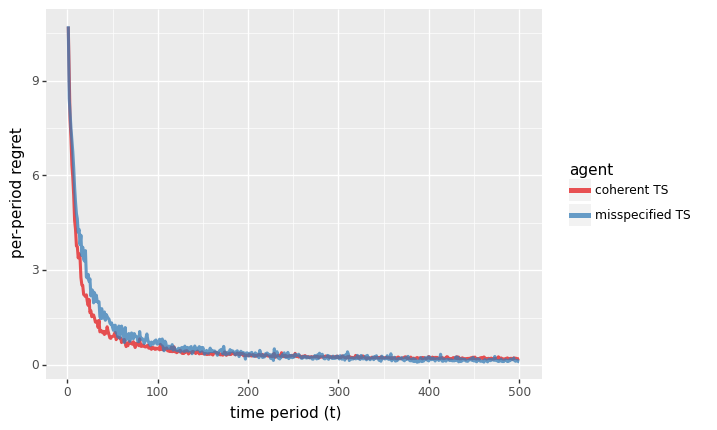

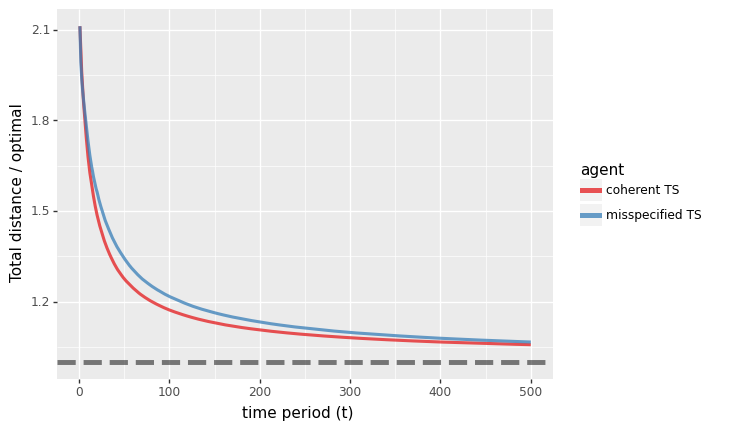

In [12]:
import pandas as pd
import plotnine as gg


def generateIndependentBBTS(n_steps, n_stages, mu0, sigma0, sigma_tilde, jobs):
    results = []
    for job_id in range(jobs):
        agent = IndependentBBTS(n_stages, mu0, sigma0, sigma_tilde)
        # 初始化环境，产生图
        env = IndependentBinomialBridge(n_stages, mu0, sigma0, sigma_tilde)
        experiment = ExperimentNoAction(
            agent, env, n_steps=n_steps, seed=job_id, unique_id=str(job_id))
        experiment.run_experiment()
        results.append(experiment.results)

    df_agent = (pd.concat(results)).assign(agent='misspecified TS')
    return df_agent


def generateCorrelatedBBTS(n_steps, n_stages, mu0, sigma0, sigma_tilde, jobs):
    results = []
    for job_id in range(jobs):
        agent = CorrelatedBBTS(n_stages, mu0, sigma0, sigma_tilde)
        env = IndependentBinomialBridge(n_stages, mu0, sigma0, sigma_tilde)
        experiment = ExperimentNoAction(
            agent, env, n_steps=n_steps, seed=job_id, unique_id=str(job_id))
        experiment.run_experiment()
        results.append(experiment.results)
    df_agent = (pd.concat(results)).assign(agent='coherent TS')
    return df_agent


def generateAgents():
    n_stages = 20
    n_steps = 500
    mu0 = -0.5
    sigma0 = 1
    sigma_tilde = 1
    N_JOBS = 200

    agents = []

    agents.append(generateIndependentBBTS(
        n_steps, n_stages, mu0, sigma0, sigma_tilde, N_JOBS))
    agents.append(generateCorrelatedBBTS(n_steps, n_stages, mu0,
                  sigma0, sigma_tilde, N_JOBS))
    df_agents = pd.concat(agents)
    return df_agents


def plotCompare1():
    df_agents = generateAgents()

    plt_df = (df_agents.groupby(['t', 'agent'])
              .agg({'instant_regret': np.mean})
              .reset_index())
    p = (gg.ggplot(plt_df)
         + gg.aes('t', 'instant_regret', colour='agent')
         + gg.geom_line(size=1.25, alpha=0.75)
         + gg.xlab('time period (t)')
         + gg.ylab('per-period regret')
         + gg.scale_colour_brewer(name='agent', type='qual', palette='Set1'))
    print(p)


def plotCompare2():
    df_agents = generateAgents()

    df_agents['cum_ratio'] = (
        df_agents.cum_optimal - df_agents.cum_regret) / df_agents.cum_optimal
    plt_df = (df_agents.groupby(['t', 'agent'])
              .agg({'cum_ratio': np.mean})
              .reset_index())
    p = (gg.ggplot(plt_df)
         + gg.aes('t', 'cum_ratio', colour='agent')
         + gg.geom_line(size=1.25, alpha=0.75)
         + gg.xlab('time period (t)')
         + gg.ylab('Total distance / optimal')
         + gg.scale_colour_brewer(name='agent', type='qual', palette='Set1')
         + gg.aes(ymin=1)
         + gg.geom_hline(yintercept=1, linetype='dashed', size=2, alpha=0.5))

    print(p)


plotCompare1()
plotCompare2()


比较表明，由于考虑了边游历时间之间的相互依赖性，结果得到了实质性的改进。